### How to download the Landsat image data and use this notebook


I created new jupyter notebook through amazon s3 with a conda_tensorflow_p36 kernel.

Instead of the landsat we were using the Landsat files. This page shows you the description of the bands of the landsat images: https://gisgeography.com/landsat-8-bands-combinations/ 

There are differnt ways of accessing the data, although I am doing it like this:

Landsat is divided into path and row(their definition of locating the tiles on earth vs latitude and longitude). You can find all data here sorted in path/row. https://landsatonaws.com/L8

In order to tell where the path/rows are you can use this:
https://landsat.usgs.gov/ard_tile

When downloading the landsat data, one column shows the cloud coverage, try to get as little as possible otherwise your whole image will be white. The RGB channels are the 2,3 and 4 I believe , refer to the link above. In this notebook I use 3,4,5 because that includes infrared which can be very informative I believe in vegetation information (look at slides i sent).

The notebook squishes the selected channels into rgb to interprate the data as a visuale image. 

I downloaded the files for the landsat8 tile im using each band seperately although there is a link to an s3 bucket at the top of each tile page, to batch download. 

Other tools to access the tiles are these, however I dont think they give you the multiband data, only the data of rgb: https://earthexplorer.usgs.gov and https://glovis.usgs.gov


I tried to find a tile that is located ontop of the area Thomas found earlier with the other tool in Brazil: 
latitude , long : -8.955555, -59.111444

path : 229 
row: 66


In [3]:
from IPython.display import Image, display, HTML
from PIL import Image
import PIL
from matplotlib import pyplot as plt
import numpy as np
import glob
import cv2
from scipy import ndimage

PIL.Image.MAX_IMAGE_PIXELS = 250608461



In [4]:

data_path = "/home/ec2-user/SageMaker/landsat_data/"


In [5]:

def show_image(data):
    '''Show one greyscale image with PIL '''

    img = data

    print ("image shape: ",img.shape)
    print ("image type: ", img.dtype)
    print ("min: {}, max: {}".format( np.min(img),np.max(img)) )

    img = (img/np.max(img) )* 255
    img.astype(np.uint8)

    img = Image.fromarray(img)
    img.show()

def load_image(dir):

    # near infrared (B5), red (B4), green bands (B3)
    images_tif = ([(Image.open(file)) for file in glob.glob(data_path +'*B[2-4]*.TIF')])

    # reshape (w x h x num_images)
    np_images = [np.array(img) for img in images_tif]
    np_images = np.stack(np_images, axis=2)
    np_images = np_images[:,:,[0,1,2]] # reverse order RGB is BGR for matplotlib
    print ("image shape: ", np_images.shape)

    return np_images

def show_image_RGB(data):
    '''Show an image as rgb or greyscale with matplotlib'''

    # img = np.clip(data, 0, 30000)
    img = data
    img = (img/np.max(img))* 255

    if (len(img.shape)<3):
        print("showing image gray scale")
        plt.imshow(img.astype('uint8'),  cmap='gray')
        # plt.show()
    else:
        print("showing image color")
        plt.imshow(img.astype('uint8'))
        # plt.show()



images:  3
image shape:  (7731, 7591, 3)
showing image color


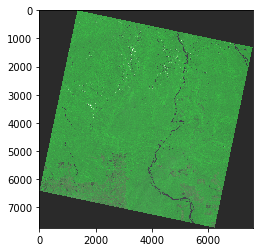

In [6]:


image = load_image(data_path)
image = np.clip(image[:,:,:], 5000, 30000) # getting rid of very big outliers
show_image_RGB(image)



In [ ]:
#### Extra Functions. Next code cell runs the code in here.
#### Basically does a better visualization through histogram normalization


def save_image(data, name):
        # img = np.clip(data, 0, 30000)
        img = data
        img = (img/np.max(img))* 255
        im = Image.fromarray(img.astype('uint8'))
        im.save(name +".jpeg")


def calc_hist(data):
    num_bins = 256
    plt.hist(data.flatten(), num_bins, facecolor='blue', alpha=0.5)
    plt.show()

def histogram_equalization(data,range, plot = False):
    ''' we know from readme file, data range is from 1 to max, and 0 is used for padding'''
    bins = range[1] - range[0] # exclude 0
  
    hist = np.histogram(data.flatten(), bins=bins, range = range)


    total_pix = hist[0].sum()

    print ("total pixels in range : ", total_pix)
    print ("total pixels in image: ", data.size)

    cum_norm_hist = np.rint(np.cumsum(hist[0]/ total_pix) * range[1])

    cum_norm_hist = cum_norm_hist.astype(int)

    # if (plot):
    #     plt.bar(hist[1][:-1], cum_norm_hist)
    #     plt.show()
    return cum_norm_hist

def apply_hist(data, hist):
    new_data = np.zeros(data.shape, data.dtype)
    return (hist[data])
    for i in range (data.shape[0]):
        for j in range(data.shape[1]):
            if (len(data.shape)<3):
                new_data[i,j] = hist[data[i][j]]
            else:
                for k in range(data.shape[2]):
                    new_data[i,j,k] = hist[data[i][j][k]]


def visualize_data(data):
    min_value = 2
    # max_value = 30000
    range =(min_value,np.max(data))
    new_hist = histogram_equalization(data,range=range)
    a = np.zeros(min_value+1, new_hist.dtype) # for the missing values

    new_hist = np.concatenate((a, new_hist))
    data_ = apply_hist(data,new_hist)

    return data_

# most common to apply edge filter to red band ...
def filter_image(image):
    kernel = np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]])
    image = ndimage.convolve(image, kernel)
    # image = ndimage.gaussian_filter(image, sigma=3)

    # image = ndimage.sobel(image)
    return image



In [ ]:
### WARNING: TAKES VERY LONG TO RUN

### equalize histogram
better_viz_image = np.zeros(image.shape,image.dtype)
for i in range(image.shape[2]):
    better_viz_image[:,:,i] = visualize_data(image[:,:,i])
# better_viz_image = visualize_data(image)


permutations = [[0,1,2],[0,2,1],[1,0,2],[1,2,0],[2,0,1],[2,1,0]]


for i, p in enumerate (permutations):
    print (i,p)
    show_image_RGB(better_viz_image[:,:,p])
    # save_image(better_viz_image[:,:,p],"false_color_{}_{}_{}".format(p[0],p[1],p[2]))
    plt.subplot(3,2,i+1)
plt.show()